In [54]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pylab as plt
from matplotlib import patches
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import seaborn as sns; sns.set()
from sklearn.metrics.pairwise import euclidean_distances
from numpy import linalg as LA

import random
from scipy.stats import multivariate_normal
import collections
import operator

## Comparison of k-means and GMM
1) The k-means model has no intrinsic measure of probability or uncertainty of cluster assignments. 
2) K-means always assumes the distribution of clusters are circular, while real-world dataset are not. 

(272, 2)


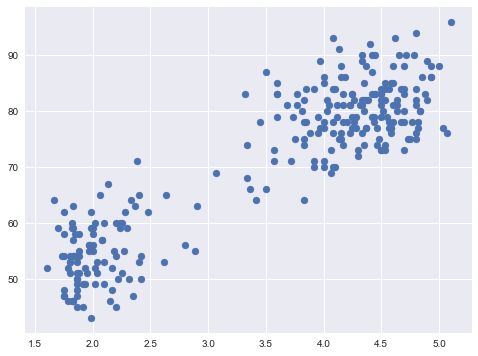

In [16]:
file = open('./data/old_faithful_geyser.dat')
data = []
for line in file.readlines()[26:]:
    data.append([float(y) for y in[x for x in line.split()[-2:]]])
data = np.array(data)
print(data.shape)

fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.scatter(data[:, 0], data[:, 1])
plt.show()

In [9]:
def normalize(X):
    return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

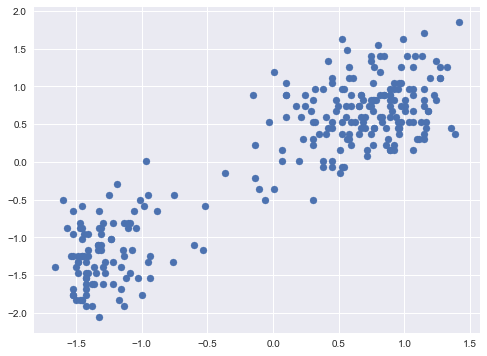

In [20]:
# normalize data
norm_data = normalize(data)
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.scatter(norm_data[:, 0], norm_data[:, 1])
plt.show()

### (c) Implement a bimodal GMM

In [43]:
class GaussianMixture2D2Class:
    # This is a simple GMM with 2D and 2 classes
    # attributes:
    #   max_iter: int. The maximum iteration times.
    #   X: data set
    #   model: miu, sigma and pi
    #   loss_0: the current loss
    #   loss_1: the loss of last 1 step
    #   loss_2: the loss of the last 2 step
    #   first_loss: the first loss for comparing convergence status
    #   iteration_step: the current steps taken for EM
    #   loss_threshold: a threshold for judging loss convergence status between steps
    #   miu1_trajectory: the trajectory path of miu1
    #   miu2_trajectory: the trajectory path of miu2
    # methods:
    #   self.fit(X): generate n_components gaussian distributions by EM
    #   self.loss(X): the weighted L2 between data points and centroids
    #   self.e_step: Expectation step
    #   self.m_step: Maximization step
    #   self.is_converged: check loss of last 3 times to see whether it is converged
    def __init__(self, max_iter=50, auto_normalize=True):
        self.max_iter = max_iter
        self.miu1_trajectory = []
        self.miu2_trajectory = []
        self.model = {}
        self.initialize_params()
        self.X = None
        self.loss_0 = float("inf")
        self.loss_1 = float("inf")
        self.loss_2 = float("inf")
        self.first_loss = float("inf")
        self.iteration_step = 0
        # Try a good threshold
        self.loss_threshold = 0.1
        self.auto_normalize = auto_normalize
    
    def initialize_params(self):
        model = {}
        miu1 = np.random.rand(2)
        miu1[0] = miu1[0] * 2
        miu1[1] = miu1[1] * 2
        self.update_model('miu1', miu1)
        self.update_model('sigma1', np.identity(2) * ((np.random.rand() + 1) * 2))
        miu2 = np.random.rand(2)
        miu2[0] = miu2[0] * 2
        miu2[1] = miu2[1] * 2
        self.update_model('miu2', np.random.rand(2)*2)
        self.update_model('sigma2', np.identity(2) * ((np.random.rand() + 1) * 2))
        self.update_model('pi', np.random.rand())
    
    # Fit GMM with EM
    def fit(self, X):
        # Iteratively run e_step and m_step till it converges
        if self.auto_normalize:
            self.X = normalize(X)
        else:
            self.X = X
        
        while self.iteration_step < self.max_iter and not self.is_converged():
            self.iteration_step += 1
            # print("-- Iter {} --".format(self.iteration_step))
            try:
                self.e_step()
            except np.linalg.LinAlgError:
                # if np.linalg.LinAlgError is triggered, there might be some initialization problems
                # then reinitialize parameters and continue on e-step
                self.initialize_params()
                self.e_step()
            self.m_step()
        print("GMM Converged in {} with loss {}".format(self.iteration_step, self.loss_0))
    
    def e_step(self):
        # Expectation step: compute responsibility on 2 classes of each data point
        gamma = np.zeros([self.X.shape[0], 2])
        pdf1 = multivariate_normal.pdf(self.X, self.model['miu1'], self.model['sigma1'])
        pdf2 = multivariate_normal.pdf(self.X, self.model['miu2'], self.model['sigma2'])
        denominator = ((1-self.model['pi'])*pdf1 + self.model['pi']*pdf2)
        gamma[:, 1] = self.model['pi']*pdf2 / denominator
        gamma[:, 0] = (1-self.model['pi'])*pdf1 / denominator
        self.gamma = gamma
    
    #### TODO: check computation of sigma
    def m_step(self):
        # Maximization step: compute weighted means and variances
        #print("M Step {}".format(self.iteration_step))        
        r1 = self.gamma[:, 0]
        denominator1 = np.sum(r1)
        self.update_model('miu1', np.dot(r1, self.X) / denominator1)
        sigma1 = np.zeros([2, 2])
        for i, x in enumerate(self.X):
            s1 = x - self.model['miu1']
            sigma1[0][0] += r1[i] * s1[0] * s1[0]
            sigma1[1][1] += r1[i] * s1[1] * s1[1]
        self.update_model('sigma1', sigma1 / denominator1)
                    
        r2 = self.gamma[:, 1]
        denominator2 = np.sum(r2)
        self.update_model('miu2', np.dot(r2, self.X) / denominator2)
        sigma2 = np.zeros([2, 2])
        for i, x in enumerate(self.X):
            s2 = x - self.model['miu2']
            sigma2[0][0] += r2[i] * s2[0] * s2[0]
            sigma2[1][1] += r2[i] * s2[1] * s2[1]
        self.update_model('sigma2', sigma2 / denominator2)
        
        self.model['pi'] = np.sum(self.gamma[:, 1]) / self.X.shape[0]
        self.loss_2 = self.loss_1
        self.loss_1 = self.loss_0
        self.loss_0 = self.loss()
        if self.iteration_step == 1:
            self.first_loss = self.loss_0
        # print("- losses: {}".format([self.loss_2, self.loss_1, self.loss_0]))
    
    def loss(self):
        ret = np.sum(np.dot(self.gamma[:, 0], euclidean_distances(self.X, [self.model['miu1']])) + \
               np.dot(self.gamma[:, 1], euclidean_distances(self.X, [self.model['miu2']])))
        
        return ret
    
    def is_converged(self):
        if self.loss_0 > self.first_loss * 0.8:
            # if after 10 iterations, the loss still has no signification decline, then reintialize the model
            if self.iteration_step > 10:
                self.initialize_params()
            return False
        return abs(self.loss_2 - self.loss_1 - self.loss_1 + self.loss_0) < self.loss_threshold    
    
    def update_model(self, key, value):
        self.model[key] = value
        if key == 'miu1':
            self.miu1_trajectory.append(value)
        if key == 'miu2':
            self.miu2_trajectory.append(value)

In [44]:
gmm = GaussianMixture2D2Class()
gmm.fit(data)

GMM Converged in 15 with loss 127.912782121


{'miu1': array([0.70510053, 0.66976716]), 'pi': 0.35652305080451424, 'miu2': array([-1.27261319, -1.20884113]), 'sigma1': array([[0.12953963, 0.        ],
       [0.        , 0.19425747]]), 'sigma2': array([[0.05420125, 0.        ],
       [0.        , 0.18331974]])}


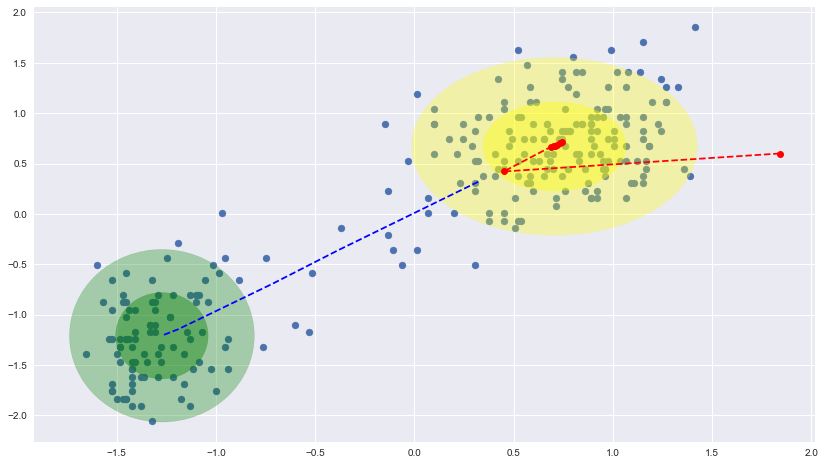

In [56]:
trained_model = gmm.model
print(trained_model)
fig, ax = plt.subplots()
fig.set_size_inches(14, 8)
plt.scatter(gmm.X[:, 0], gmm.X[:, 1])
# np.sqrt(trained_model['sigma1'][0][0])
circle_1 = patches.Ellipse(trained_model['miu1'], np.sqrt(trained_model['sigma1'][0][0])*2, np.sqrt(trained_model['sigma1'][1][1])*2, alpha=0.4, color='yellow')
circle_2 = patches.Ellipse(trained_model['miu2'], np.sqrt(trained_model['sigma2'][0][0])*2, np.sqrt(trained_model['sigma2'][1][1])*2, alpha=0.4, color='green')
circle_3 = patches.Ellipse(trained_model['miu1'], np.sqrt(trained_model['sigma1'][0][0])*4, np.sqrt(trained_model['sigma1'][1][1])*4, alpha=0.3, color='yellow')
circle_4 = patches.Ellipse(trained_model['miu2'], np.sqrt(trained_model['sigma2'][0][0])*4, np.sqrt(trained_model['sigma2'][1][1])*4, alpha=0.3, color='green')
ax.add_patch(circle_1)
ax.add_patch(circle_2)
ax.add_patch(circle_3)
ax.add_patch(circle_4)
miu1_trajectory = np.array(gmm.miu1_trajectory)
miu2_trajectory = np.array(gmm.miu2_trajectory)
plt.plot(miu1_trajectory[:, 0], miu1_trajectory[:, 1], marker='o', linestyle='--', color='r', label='Trajectory of Miu 1')
plt.plot(miu2_trajectory[:, 0], miu2_trajectory[:, 1], marker='x', linestyle='--', color='b', label='Trajectory of Miu 2')
plt.show()

GMM Converged in 11 with loss 127.912901942
GMM Converged in 9 with loss 127.91195958
GMM Converged in 9 with loss 127.912533615
GMM Converged in 12 with loss 127.911710974
GMM Converged in 11 with loss 127.912779669
GMM Converged in 9 with loss 127.912637647
GMM Converged in 8 with loss 127.912793326
GMM Converged in 11 with loss 127.911420301
GMM Converged in 11 with loss 127.912770223
GMM Converged in 11 with loss 127.913163693
GMM Converged in 10 with loss 127.91306643
GMM Converged in 10 with loss 127.911930081
GMM Converged in 8 with loss 127.912458559
GMM Converged in 10 with loss 127.911716907
GMM Converged in 9 with loss 127.912204227
GMM Converged in 11 with loss 127.91255933
GMM Converged in 10 with loss 127.912771071
GMM Converged in 9 with loss 127.912992743
GMM Converged in 11 with loss 127.912372359
GMM Converged in 12 with loss 127.91283752
GMM Converged in 12 with loss 127.912806246
GMM Converged in 9 with loss 127.912667652
GMM Converged in 11 with loss 127.911516739


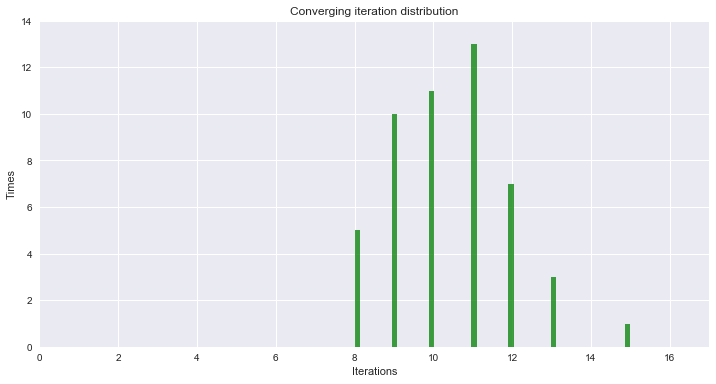

In [51]:
# Run 50 times and observe the converging iteration distributions
iterations = []
for i in range(50):
    gmm = GaussianMixture2D2Class()
    gmm.fit(data)
    step = gmm.iteration_step
    #if step > len(iterations):
    #    iterations.extend(list(np.zeros(step - len(iterations))))
    #iterations[step-1] += 1
    iterations.append(step)
# print(iterations)
counts = collections.Counter(iterations)
max_count = sorted(counts.items(), key=operator.itemgetter(1))[-1][1]
max_step = sorted(counts.items(), key=operator.itemgetter(0))[-1][0]

fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
n, bins, patches = plt.hist(iterations, len(iterations)+2, facecolor='g', alpha=0.75)
plt.xlabel('Iterations')
plt.ylabel('Times')
plt.title('Converging iteration distribution')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.axis([0, max_step+2, 0, max_count+1])
plt.grid(True)
plt.show()

###  (d) k-means

(array([[ 4.29793023, 80.28488372],
       [ 2.09433   , 54.75      ]]), [15.735571027977631, 12.250061035313282])
2


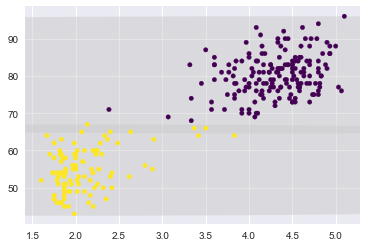

In [11]:
# kmeans = KMeans(n_clusters = 2, random_state=0).fit(data)
# labels = kmeans.labels_
# print(labels)
def plot_kmeans(kmeans, X, n_clusters=2, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.scatter([item[0] for item in X],[item[1] for item in X], c=labels, s=20, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = []
    for i in range(0,2):
        dist = []
        for d in data[labels == i]:
            dist.append(LA.norm(d-centers[i]))
        radii.append(max(dist))
    print(centers,radii)
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=5, alpha=0.5, zorder=1))

# scale the data
# scaler = StandardScaler()
# scaler.fit(data)
# data_scaled = scaler.transform(data)

kmeans = KMeans(n_clusters=2, random_state=0)
plot_kmeans(kmeans, data)
print(kmeans.n_iter_)

--------------------

### Test Code